# Semantic Segmentation project 2 PH dataset

We provide you with a class similar to the Hotdog_NotHotdog data loader that will allow you to load the dataset from  /dtu/datasets1/02514/

First, we load some needed libraries

In [4]:
import os
import numpy as np
import glob
import PIL.Image as Image
import os

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import random
from omegaconf import OmegaConf

from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateFinder

from src.utils import accuracy, specificity, sensitivity, iou, dice, get_loaders
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [18, 6]

Next, the data loader

### Considerations:
- images are typically centered and edges are irrelevant
    - thus UNet is appropriate

## Device

Check if GPU is available.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Modelling

In [31]:
DATASET = 'DRIVE'
studynumber = 's184984'

loaders = get_loaders(DATASET, batch_size=6)

# Define arguments
args = OmegaConf.create({
    'experiment_name': 'test',
    'network_name': 'test',

    'data_path': '/dtu/datasets1/02514/PH2_Dataset_images' if DATASET == 'PH2' else '/dtu/datasets1/02514/DRIVE',
    'log_path': f'/work3/{studynumber}/02514/DL-COMVIS/logs/project2',
    'save_path': f'/work3/{studynumber}/02514/DL-COMVIS/models/project2',
    
    'seed': 0,
    'verbose': False,
    'log_every_n': 2,

    'batch_size': 6,
    'optimizer': 'Adam',
    'lr': 1e-3,
    'initial_lr_steps': -1,
    'epochs': 100,
    'num_workers': 24,
    'devices': -1,
    'verbose': False,
})


In [32]:

### BASEMODEL ###
class BaseModel(pl.LightningModule):
    def __init__(self, args, loss_fun, logs, metrics, optimizer):
        super().__init__()
        self.args = args
        self.lr = self.args.lr
        self.loss_fun = loss_fun
        self.logs = logs
        self.metrics = metrics
        self.optimizer = optimizer
        self.log_dict = {}
        
        # checkpointing and logging
        self.model_checkpoint = ModelCheckpoint(
            monitor = "val_loss",
            verbose = args.verbose,
            filename = "{epoch}_{val_loss:.4f}",
        )
        
        self.save_hyperparameters()

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr = self.args.lr)
        
    def training_step(self, batch, batch_idx):
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        # metrics
        y_hat_sig = F.sigmoid(y_hat)
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # log
        for name, fun in self.logs.items():
            self.log('train_'+name, fun(y_hat_sig, y), prog_bar=True, logger=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        y_hat_sig = F.sigmoid(y_hat)
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # log
        for name, fun in self.logs.items():
            self.log('val_'+name, fun(y_hat_sig, y), prog_bar=True, logger=True)
        for name, fun in self.metrics.items():
            self.log('val_'+name, fun(y_hat_sig, y))
        self.log("val_loss", loss, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx): 
        # extract input
        x, y = batch
        # predict
        y_hat = self.forward(x)
        # loss
        loss = self.loss_fun(y, y_hat)
        # predicting
        y_hat_sig = F.sigmoid(y_hat)#.detach().cpu() # todo?
        threshold = torch.tensor([0.5],device=device)

        y_hat_sig = (y_hat_sig>threshold).float()*1
        y_hat_sig = y_hat_sig.int()
        y = y.int()
        # getting output values
        self.log('Test loss', loss) #, prog_bar=True)
        for name, fun in self.logs.items():
            self.log('Test '+name, fun(y_hat_sig, y))
        for name, fun in self.metrics.items():
            self.log('Test '+name, fun(y_hat_sig, y))


In [33]:
class EncDec(BaseModel):
    def __init__(self, args, loss_fun, logs, metrics, optimizer):
        super().__init__(args, loss_fun, logs, metrics, optimizer)
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3


In [34]:
# define parameters
def bce_loss(y_real, y_pred):
    return F.binary_cross_entropy_with_logits(y_pred, y_real)

loss_fun = bce_loss
optimizer = optim.Adam
logs = {
    'acc': accuracy,
}

metrics = {
    'Dice overlap': dice,
    'IoU'         : iou,
    'Sensitivity' : sensitivity,
    'Specificity' : specificity,
}

In [35]:
# define model
model = EncDec(args, loss_fun, logs, metrics, optimizer).to(device)


In [36]:
summary(model, (3, 288, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 384]           1,792
         MaxPool2d-2         [-1, 64, 144, 192]               0
            Conv2d-3         [-1, 64, 144, 192]          36,928
         MaxPool2d-4           [-1, 64, 72, 96]               0
            Conv2d-5           [-1, 64, 72, 96]          36,928
         MaxPool2d-6           [-1, 64, 36, 48]               0
            Conv2d-7           [-1, 64, 36, 48]          36,928
         MaxPool2d-8           [-1, 64, 18, 24]               0
            Conv2d-9           [-1, 64, 18, 24]          36,928
         Upsample-10           [-1, 64, 36, 48]               0
           Conv2d-11           [-1, 64, 36, 48]          36,928
         Upsample-12           [-1, 64, 72, 96]               0
           Conv2d-13           [-1, 64, 72, 96]          36,928
         Upsample-14         [-1, 64, 1

## Training

In [37]:
# Set up logger

tb_logger = TensorBoardLogger(
    save_dir=f"{args.log_path}/{args.experiment_name}",
    version=None,
    name=args.network_name,
)


# Setup trainer
trainer = pl.Trainer(
    devices=args.devices, 
    accelerator='gpu', 
    max_epochs = args.epochs,
    log_every_n_steps = args.log_every_n,
    callbacks=[model.model_checkpoint] if args.initial_lr_steps == -1 else [model.model_checkpoint, model.lr_finder],
    logger=tb_logger,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
fold = 0
# for fold in range(20):

# Train model
trainer.fit(
    model=model,
    train_dataloaders = loaders['train'] if DATASET == 'PH2' else loaders[fold]['train'],
    val_dataloaders = loaders['validation'] if DATASET == 'PH2' else loaders[fold]['validation'],
) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type      | Params
-----------------------------------------------
0  | enc_conv0       | Conv2d    | 1.8 K 
1  | pool0           | MaxPool2d | 0     
2  | enc_conv1       | Conv2d    | 36.9 K
3  | pool1           | MaxPool2d | 0     
4  | enc_conv2       | Conv2d    | 36.9 K
5  | pool2           | MaxPool2d | 0     
6  | enc_conv3       | Conv2d    | 36.9 K
7  | pool3           | MaxPool2d | 0     
8  | bottleneck_conv | Conv2d    | 36.9 K
9  | upsample0       | Upsample  | 0     
10 | dec_conv0       | Conv2d    | 36.9 K
11 | upsample1       | Upsample  | 0     
12 | dec_conv1       | Conv2d    | 36.9 K
13 | upsample2       | Upsample  | 0     
14 | dec_conv2       | Conv2d    | 36.9 K
15 | upsample3       | Upsample  | 0     
16 | dec_conv3       | Conv2d    | 577   
-----------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.043     Total estimate

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [39]:
# for fold in range(20):

trainer.test(model, dataloaders=loaders['test'] if DATASET == 'PH2' else loaders[fold]['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Test Dice overlap     │            0.0            │
│         Test IoU          │            0.0            │
│     Test Sensitivity      │            0.0            │
│     Test Specificity      │            1.0            │
│         Test acc          │    0.9907646179199219     │
│         Test loss         │    0.2406470775604248     │
└───────────────────────────┴───────────────────────────┘

[{'Test loss': 0.2406470775604248,
  'Test acc': 0.9907646179199219,
  'Test Dice overlap': 0.0,
  'Test IoU': 0.0,
  'Test Sensitivity': 0.0,
  'Test Specificity': 1.0}]

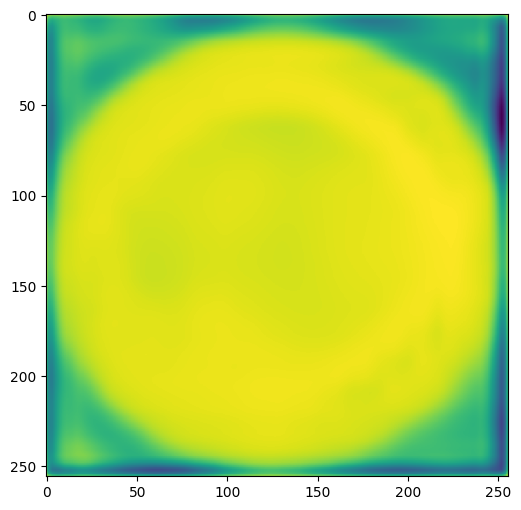

In [40]:
x = next(iter(loaders['test']))[0] if DATASET == 'PH2' else next(iter(loaders[fold]['test']))[0]
plt.imshow(model(x).detach().numpy()[0].transpose(1,2,0))